In [198]:
import pandas as pd
import numpy as np
from collections import Counter
import random
from sklearn.feature_extraction import DictVectorizer as DV
from xgboost import XGBClassifier

from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.model_selection import KFold
from catboost.utils import create_cd
from bayes_opt import BayesianOptimization
import copy

from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import RidgeClassifier

In [1]:
import lightgbm as lgb

/Users/maxim/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [199]:
from sklearn.metrics import accuracy_score
true = pd.read_csv("true_ans.csv")
y_test = true["Survived"].values
def get_ac(ans):
    return accuracy_score(ans, true["Survived"])

In [200]:
X_test= pd.read_pickle("test_anses.pk")
X_train= pd.read_pickle("train_anses.pk")
X_train_proba = pd.read_pickle("train_proba.pk")
X_test_proba=pd.read_pickle("test_proba.pk")

In [201]:
y_train = X_train_proba["target"]
X_train_proba.drop(columns=["target"], inplace = True)

In [202]:
def get_model(**params):
    print(params)
    return DecisionTreeClassifier(**params)

def validate(model, X_train, y_train, X_val, y_val, verbose=0,n =3):
    model1 = copy.deepcopy(model)
    kfold = KFold(n, True, 1)
    current_score = 0
    for train, test in kfold.split(X_train): 
        model1.fit(X_train.iloc[train], y_train.values[train], 


        )
        print(model1.get_params())
        probs = model1.predict(X_train.iloc[test])
        current_score += accuracy_score(probs, y_train.values[test])
    if True:
        print(current_score/n)
        
    return current_score/n

def evaluate_model(**params):
    params_init = {
           "max_depth" : 1,
    "min_samples_split": 1,
    "min_samples_leaf" : 1, 
    "max_features":3,
    "max_leaf_nodes":1,
    }
    params_init.update(params)
    params_init["random_state"] = 0
    params_init["class_weight"] = {0 : 1, 1: 0.8}
    params_init["max_depth" ] = int(params_init["max_depth" ])
    params_init["max_features" ] = int(params_init["max_features" ])
    params_init["max_leaf_nodes" ] = int(params_init["max_leaf_nodes" ])
    model = get_model(**params_init)
    current_score = validate(model, X_train_proba, y_train, X_test_proba, y_test, verbose=0)
    return current_score

In [73]:
pbounds = {
    "max_depth" : (1, 5),
    "min_samples_split": (0.000001, 1),
    "min_samples_leaf" : (0.000001, 0.5), 
    "max_features":(3, 16),
    "max_leaf_nodes":(2, 5),
    
}

In [74]:
optimizer = BayesianOptimization(evaluate_model, pbounds, random_state=4)

logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTMIZATION_STEP, logger)

optimizer.maximize(init_points=1, n_iter=20)

optimizer.res

# optimized params y

{'max_depth': 4, 'min_samples_split': 0.6977291268684462, 'min_samples_leaf': 0.35740828202118863, 'max_features': 10, 'max_leaf_nodes': 4, 'random_state': 0, 'class_weight': {0: 1, 1: 0.8}}
{'class_weight': {0: 1, 1: 0.8}, 'criterion': 'gini', 'max_depth': 4, 'max_features': 10, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 0.35740828202118863, 'min_samples_split': 0.6977291268684462, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
{'class_weight': {0: 1, 1: 0.8}, 'criterion': 'gini', 'max_depth': 4, 'max_features': 10, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 0.35740828202118863, 'min_samples_split': 0.6977291268684462, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
{'class_weight': {0: 1, 1: 0.8}, 'criterion': 'gini', 'max_depth': 4, 'max_features': 10, 'max_leaf_nodes': 4, 'min_impurity_de

ValueError: max_features must be in (0, n_features]

In [33]:
params= {'max_depth': 4,
   'min_child_weight': 1,
   'n_estimators': 299,
        "seed": 0}
model = XGBClassifier(**params)

In [34]:
model.fit(X_train_proba[col].values, y_train.values, verbose = True)
ans = model.predict(X_test_proba[col].values)
accuracy_score(ans, y_test)

0.7751196172248804

In [64]:
len(X_train.columns)

16

In [76]:
model = RidgeClassifier()

In [87]:
model.fit(X_train_proba[col].values, y_train.values)
ans = model.predict(X_test_proba[col].values)
accuracy_score(ans, y_test)

0.7607655502392344

In [89]:
for we, name in zip(model.coef_[0], X_train_proba[col].columns):
    print(name + " : " + f"{we}")


0 Random Forest : 0.0783032650314347
1 Random Forest : 0.1569777742418672
2 Random Forest : -0.1033984536517069
0 xgb : -0.09534814551284705
1 xgb : 0.4694158459436655
2 xgb : 0.7328927337379428
0 grad boost : 0.9253053486575747
1 grad boost : 0.530139602457595
2 grad boost : -0.0991453456411875
0 cat boost : -0.29764847945979905
1 cat boost : -0.1609787216455159
2 cat boost : -0.15541447627508165


In [83]:
model.coef_[0]

array([ 0.0557417 ,  0.1093209 , -0.06877966, -0.04482145,  0.27946472,
        0.40908924,  0.67500005,  0.08945686,  0.13873541,  0.52435393,
        0.37439771, -0.20067045, -0.12739742, -0.12344108, -0.08743637])

In [203]:
X_train_proba.columns

Index(['0 Random Forest', '1 Random Forest', '2 Random Forest',
       '3 Random Forest', '4 Random Forest', '0 neural net', '1 neural net',
       '2 neural net', '3 neural net', '4 neural net', '0 xgb', '1 xgb',
       '2 xgb', '3 xgb', '4 xgb', '0 neigh', '1 neigh', '2 neigh', '3 neigh',
       '4 neigh', '0 grad boost', '1 grad boost', '2 grad boost',
       '3 grad boost', '4 grad boost', '0 cat boost', '1 cat boost',
       '2 cat boost', '3 cat boost', '4 cat boost'],
      dtype='object')

In [194]:
col = ['0 Random Forest', '1 Random Forest', '2 Random Forest',
       '3 Random Forest', '4 Random Forest', '0 xgb', '1 xgb',
       '2 xgb', '3 xgb', '4 xgb', '0 neigb', '1 neigb', '2 neigb', '3 neigb',
       '4 neigb', '0 grad boost', '1 grad boost', '2 grad boost',
       '3 grad boost', '4 grad boost', '0 cat boost', '1 cat boost',
       '2 cat boost', '3 cat boost', '4 cat boost']

In [100]:
import seaborn

In [106]:
X_train_proba["target"] = y_train

/Users/maxim/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/maxim/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


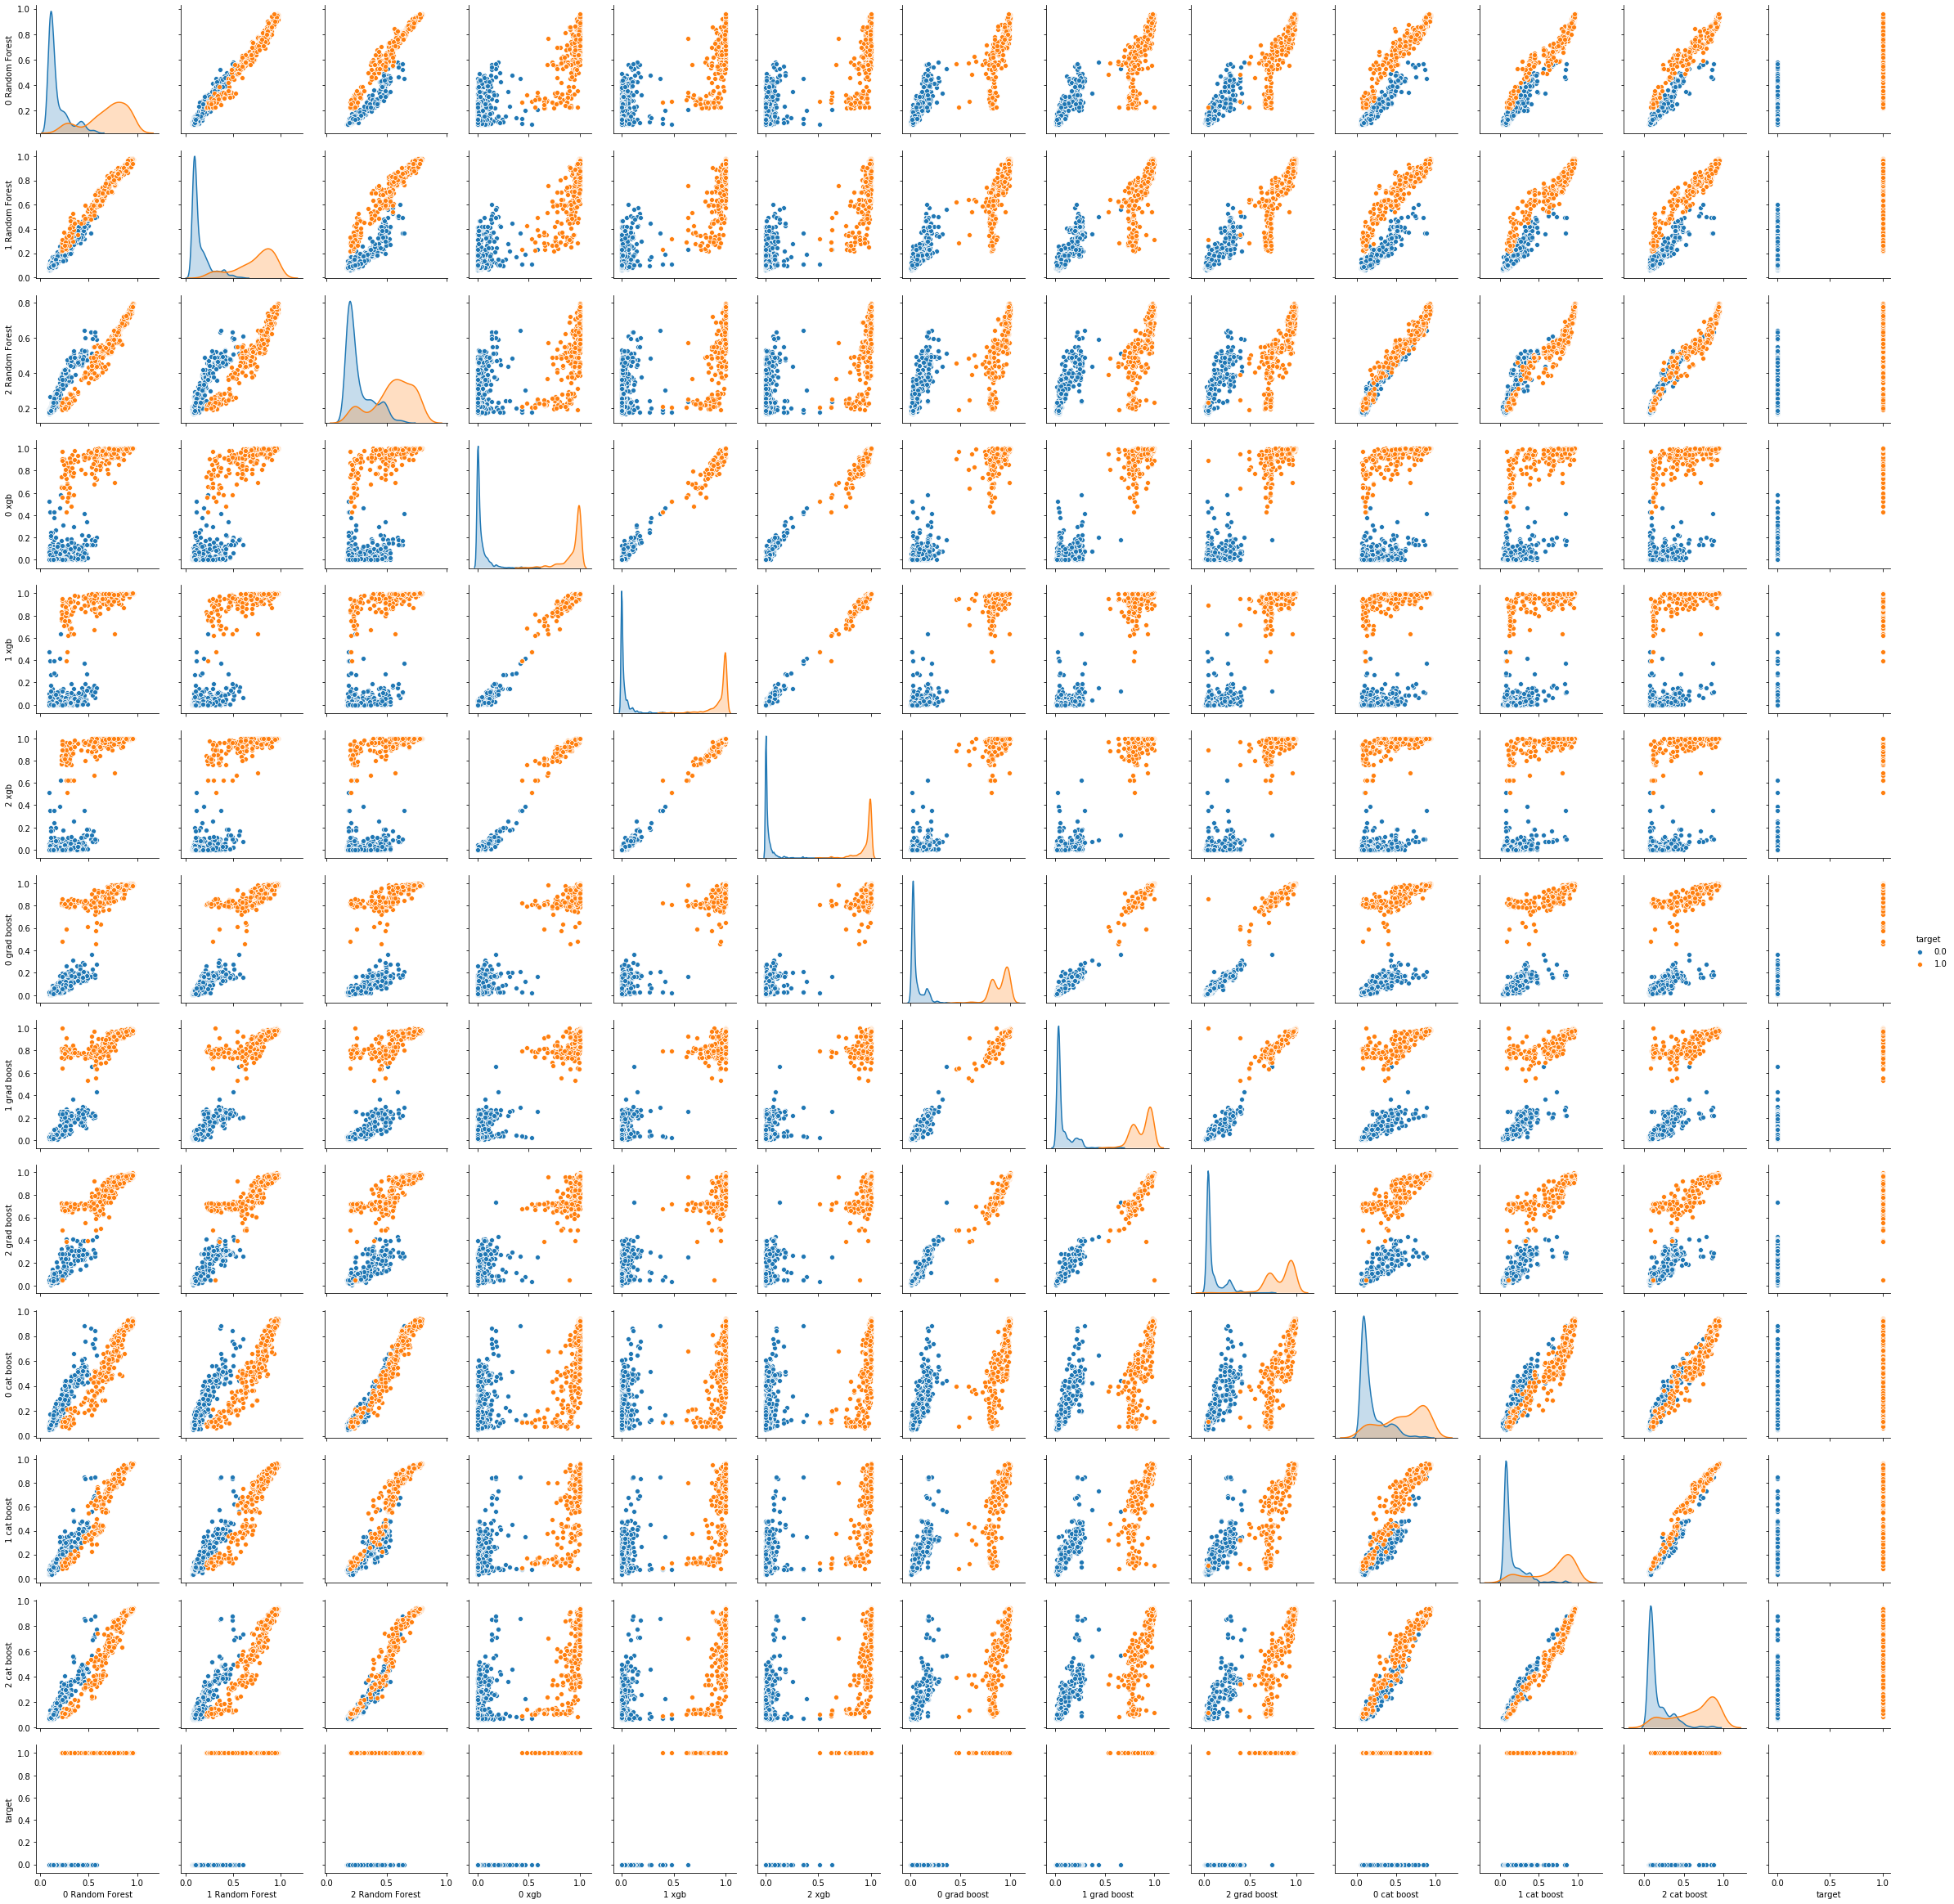

In [107]:
seaborn.pairplot(X_train_proba[col+["target"]], hue = "target")

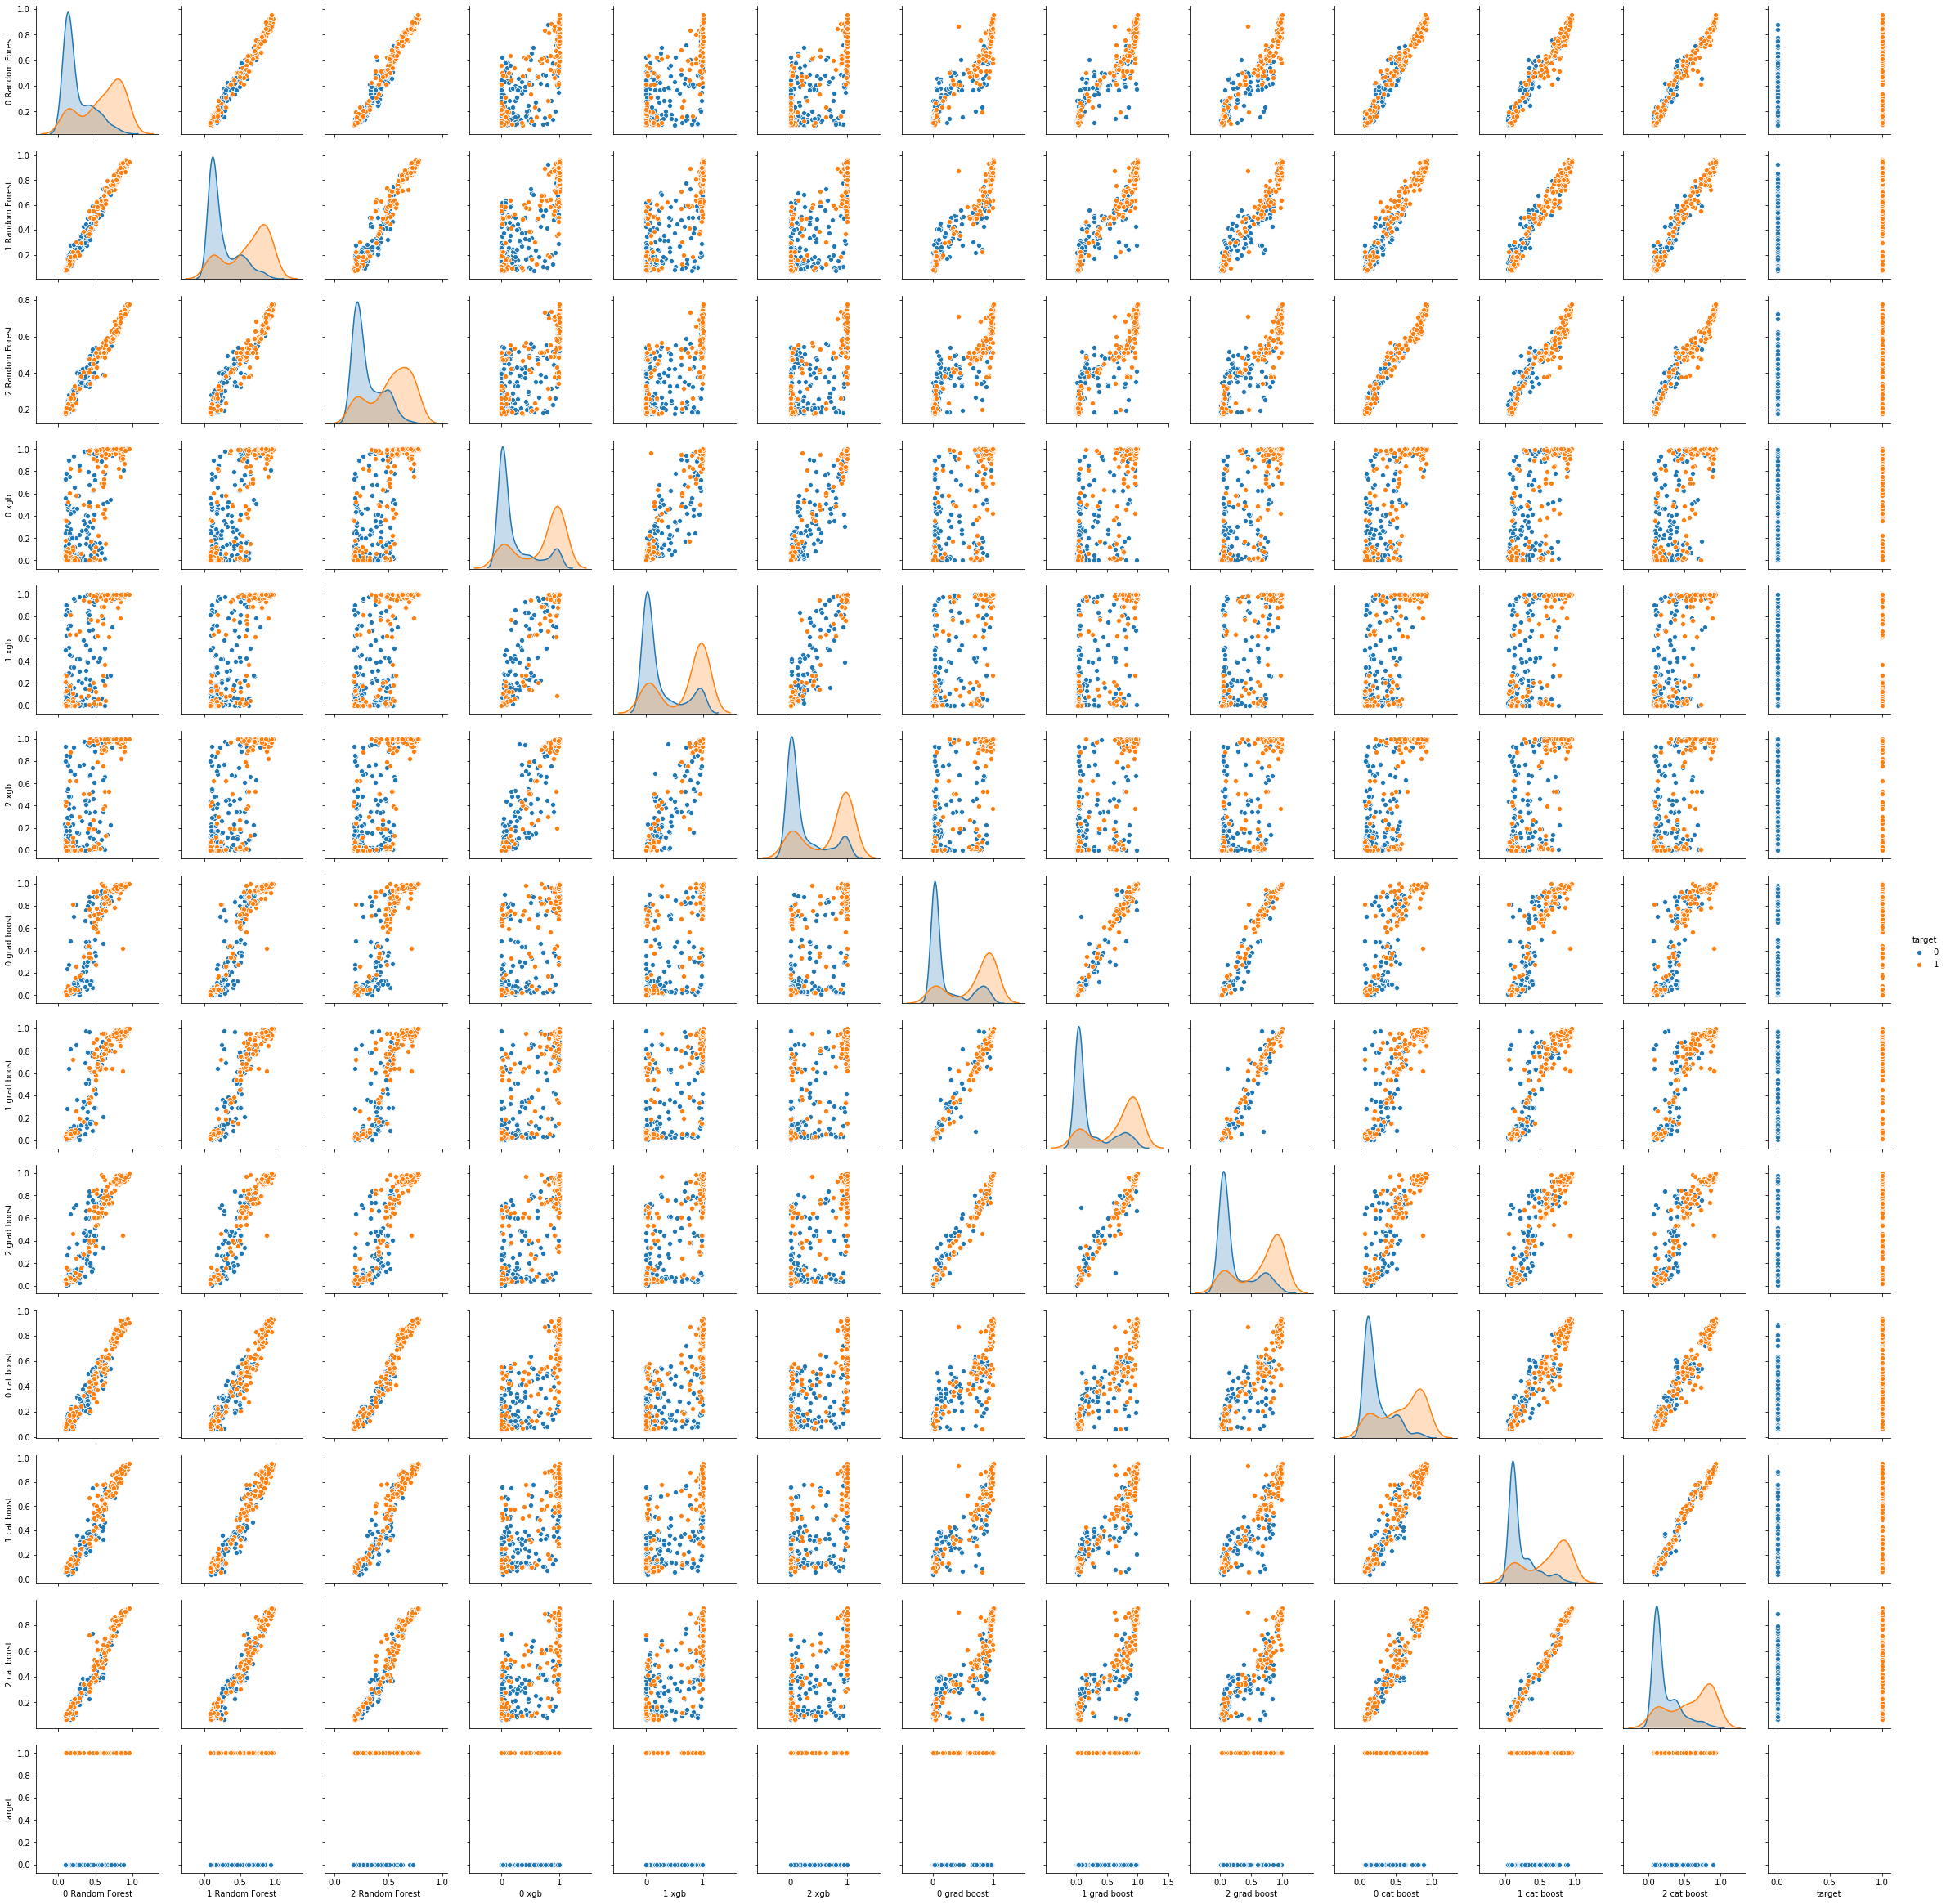

In [108]:
X_test_proba["target"] = y_test
seaborn.pairplot(X_test_proba[col+["target"]], hue = "target")

In [204]:
from sklearn.neighbors import KNeighborsClassifier

In [205]:
model = KNeighborsClassifier(n_neighbors=4, p = 2)

In [206]:
model.fit(X_train_proba[col], y_train)

KeyError: "['1 neigb', '0 neigb', '4 neigb', '2 neigb', '3 neigb'] not in index"

In [207]:
ans = model.predict(X_test_proba[col])

NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [208]:
accuracy_score(ans, y_test)

0.7703349282296651

In [209]:
X_test.columns

Index(['0 Random Forest', '1 Random Forest', '2 Random Forest',
       '3 Random Forest', '4 Random Forest', '0 neural net', '1 neural net',
       '2 neural net', '3 neural net', '4 neural net', '0 xgb', '1 xgb',
       '2 xgb', '3 xgb', '4 xgb', '0 neigb', '1 neigb', '2 neigb', '3 neigb',
       '4 neigb', '0 grad boost', '1 grad boost', '2 grad boost',
       '3 grad boost', '4 grad boost', '0 cat boost', '1 cat boost',
       '2 cat boost', '3 cat boost', '4 cat boost'],
      dtype='object')

In [210]:
from sklearn.cluster import MeanShift

In [211]:
def get_final_ans(X_test_proba, h = 0.5):
    ans = np.zeros(X_test_proba.shape[0])
    for i, pred in enumerate(X_test_proba.values):
        ms = MeanShift(bandwidth=h)
        sam = pred.reshape(-1, 1)
        ms.fit(sam)
        a = ms.predict(sam)
        unique, counts = np.unique(a, return_counts=True)
        cluster = unique[np.where(counts == counts.max())[0][0]]
        ans[i] = pred[a == cluster].mean()
    return ans

In [212]:
def get_acc(ans, y_test):
    acc = []
    tr = np.linspace(0, 1, 20)
    for t in tr:
        a = ans.copy()
        a[a > t] = 1
        a[a <= t] = 0
        acc.append(accuracy_score(a, y_test))
    acc = np.array(acc)
    return acc.max(), tr[acc == acc.max()]

In [213]:
ans = get_final_ans(X_test_proba[col], h = 0.46315789)

In [214]:
a, b = get_acc(ans, y_test)

In [215]:
t = 0.63157895
ans[ans > t] = 1
ans[ans <= t] = 0

In [216]:
ans

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [217]:
h = np.linspace(0.4, 0.6, 20)
acc = []
for H in h:
    ans = get_final_ans(X_test_proba[col], h = H)
    acc.append(get_acc(ans, y_test)[0])
    
acc = np.array(acc)

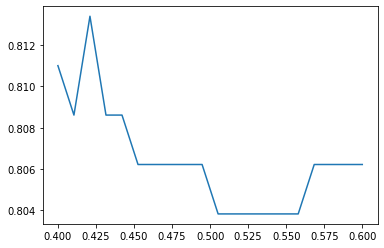

In [218]:
plt.plot(h, acc)

In [219]:
acc.max()

0.8133971291866029

In [220]:
h[acc == acc.max()]

array([0.42105263])

In [222]:
X_test_proba[col]

,0 Random Forest,1 Random Forest,2 Random Forest,3 Random Forest,4 Random Forest,0 xgb,1 xgb,2 xgb,3 xgb,4 xgb,...,0 grad boost,1 grad boost,2 grad boost,3 grad boost,4 grad boost,0 cat boost,1 cat boost,2 cat boost,3 cat boost,4 cat boost
0,0.164781,0.119652,0.091427,0.139409,0.094666,0.000770,0.011602,0.002709,0.000402,0.000271,...,0.038098,0.031067,0.061708,0.048007,0.045419,0.134040,0.126829,0.099067,0.126829,0.099067
1,0.498489,0.547772,0.505242,0.524737,0.479587,0.087868,0.010737,0.113235,0.047961,0.004087,...,0.362800,0.633391,0.456470,0.600511,0.520645,0.431868,0.449387,0.378914,0.449387,0.378914
2,0.193197,0.108973,0.132052,0.118397,0.123223,0.204262,0.042507,0.092140,0.089410,0.055018,...,0.028999,0.025982,0.046968,0.037783,0.029493,0.129418,0.146594,0.073065,0.146594,0.073065
3,0.175553,0.157177,0.138262,0.164541,0.133080,0.686038,0.734156,0.337376,0.698046,0.828724,...,0.034796,0.024417,0.053992,0.040101,0.034840,0.136831,0.104747,0.078237,0.104747,0.078237
4,0.554377,0.596410,0.576060,0.558890,0.555635,0.963843,0.990810,0.883318,0.916356,0.996562,...,0.730869,0.811085,0.665483,0.728121,0.756929,0.560985,0.459732,0.626522,0.459732,0.626522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.156756,0.109092,0.095019,0.109308,0.083652,0.005537,0.029432,0.007674,0.002243,0.005703,...,0.027642,0.031054,0.066006,0.043513,0.038037,0.148206,0.105843,0.085386,0.105843,0.085386
414,0.776016,0.833780,0.876856,0.870791,0.884930,0.999230,0.997052,0.998669,0.995661,0.999630,...,0.977909,0.975882,0.964075,0.981142,0.972961,0.720570,0.814423,0.855894,0.814423,0.855894
415,0.140953,0.101839,0.086960,0.103594,0.071138,0.049389,0.010825,0.028460,0.007137,0.038090,...,0.023689,0.017673,0.038749,0.028998,0.033262,0.113655,0.095147,0.083118,0.095147,0.083118
416,0.140361,0.094811,0.080107,0.094983,0.069609,0.006163,0.001678,0.010641,0.013692,0.002430,...,0.034796,0.024417,0.053992,0.040101,0.034840,0.121656,0.095283,0.074375,0.095283,0.074375


In [2]:
X_test_proba[col]

NameError: name 'X_test_proba' is not defined